In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,KFold,GridSearchCV
from sklearn.metrics import accuracy_score,fbeta_score,f1_score
import numpy as np
import matplotlib.pyplot as plt
from helpers import make_complexity_curve, make_learning_curve,make_timing_curve,make_timing_curve_fixed
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

**Load Cleaned Adult Data**

In [2]:
adult_df = pd.read_csv(filepath_or_buffer="adult_cleaned.csv")
adult_df_dummies = pd.get_dummies(adult_df.drop('target', 1))
adult_x = adult_df_dummies.copy().values
adult_y = adult_df["target"].copy().values
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(adult_x, adult_y, test_size=0.2,random_state=0)
print(f"adult_df: {adult_df.shape}")
print(f"X_adult_train: {X_adult_train.shape}")
print(f"X_adult_test: {X_adult_test.shape}")
print(f"y_adult_train: {y_adult_train.shape}")
print(f"y_adult_test: {y_adult_test.shape}")
print(f"y_adult_train pos: {(y_adult_train > 0).sum() / len(y_adult_train)}")
print(f"y_adult_train neg: {(y_adult_train == 0).sum() / len(y_adult_train)}")
pipeAdult = Pipeline([('Scale',StandardScaler())])
X_trans_adult_train = pipeAdult.fit_transform(X_adult_train, y_adult_train)
print(f"X_tran_adult_train: {X_trans_adult_train.shape}")

adult_df: (30162, 13)
X_adult_train: (24129, 70)
X_adult_test: (6033, 70)
y_adult_train: (24129,)
y_adult_test: (6033,)
y_adult_train pos: 0.2489535413817398
y_adult_train neg: 0.7510464586182601
X_tran_adult_train: (24129, 70)


**Load Spam**

In [3]:
spam_df = pd.read_csv('spambase.csv', header=0)
spam_x = spam_df.drop('class', axis=1).copy().values
spam_y = spam_df['class'].copy().values
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(spam_x, spam_y, test_size=0.2,random_state=0)
print(f"spam_df: {spam_df.shape}")
print(f"X_spam_train: {X_spam_train.shape}")
print(f"X_spam_test: {X_spam_test.shape}")
print(f"y_spam_train: {y_spam_train.shape}")
print(f"y_spam_test: {y_spam_test.shape}")
print(f"y_spam_train pos: {(y_spam_train > 0).sum() / len(y_spam_train)}")
print(f"y_spam_train neg: {(y_spam_train == 0).sum() / len(y_spam_train)}")
pipeSpam = Pipeline([('Scale',StandardScaler())])
X_trans_spam_train = pipeSpam.fit_transform(X_spam_train, y_spam_train)
print(f"X_tran_spam_train: {X_trans_spam_train.shape}")

spam_df: (4601, 58)
X_spam_train: (3680, 57)
X_spam_test: (921, 57)
y_spam_train: (3680,)
y_spam_test: (921,)
y_spam_train pos: 0.38858695652173914
y_spam_train neg: 0.6114130434782609
X_tran_spam_train: (3680, 57)


In [4]:
def getParams(nFeatures):
    alphas = [10**-x for x in np.arange(-1,5.01,1/2)]
    hiddens = [(h,)*l for l in [1,2,3] for h in [nFeatures,nFeatures//2,nFeatures*2]]
    params = {
        'MLP__activation':['relu','logistic'],
        'MLP__alpha':alphas,
        'MLP__hidden_layer_sizes':hiddens
    }
    return params
adultParams = getParams(X_trans_adult_train.shape[1])
spamParams = getParams(X_trans_spam_train.shape[1])

In [5]:
pipeAdult = Pipeline([
    ('Scale',StandardScaler()),
    ('MLP',MLPClassifier(max_iter=2000,early_stopping=True,random_state=55))
])
adult_cv = GridSearchCV(pipeAdult,param_grid=getParams(X_trans_adult_train.shape[1]), cv=5)
adult_cv.fit(X_trans_adult_train, y_adult_train)
print(f"best params adult: {adult_cv.best_params_}")

best params adult: {'MLP__activation': 'relu', 'MLP__alpha': 1.0, 'MLP__hidden_layer_sizes': (70,)}


In [6]:
pipeSpam = Pipeline([
    ('Scale',StandardScaler()),
    ('MLP',MLPClassifier(max_iter=2000,early_stopping=True,random_state=55))
])
spam_cv = GridSearchCV(pipeSpam,param_grid=getParams(X_trans_spam_train.shape[1]), cv=5)
spam_cv.fit(X_trans_spam_train, y_spam_train)
print(f"best params spam: {spam_cv.best_params_}")

best params spam: {'MLP__activation': 'relu', 'MLP__alpha': 0.00031622776601683794, 'MLP__hidden_layer_sizes': (57, 57, 57)}


In [7]:
adult_clf = MLPClassifier(max_iter=2000,early_stopping=True,random_state=55, activation='relu', alpha=1.0, hidden_layer_sizes=(70,))

In [8]:
spam_clf = MLPClassifier(max_iter=2000,early_stopping=True,random_state=55, alpha=1.0,hidden_layer_sizes=(57, 57, 57))

**Complexity**

In [9]:
alphas = [10**x for x in np.arange(-5,2,1,dtype=float)]
adult_cc_alphas = make_complexity_curve(adult_clf, X_trans_adult_train, y_adult_train, "alpha",alphas,"ann complexity alphas", "adult")

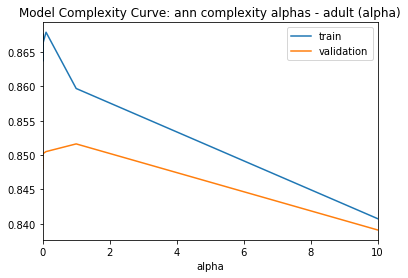

In [10]:
adult_cc_alphas.plot(title=adult_cc_alphas.name)

In [11]:
alphas = [10**x for x in np.arange(-5,2,1,dtype=float)]
spam_cc_alphas = make_complexity_curve(spam_clf, X_trans_spam_train, y_spam_train, "alpha",alphas,"ann complexity alphas", "spam")

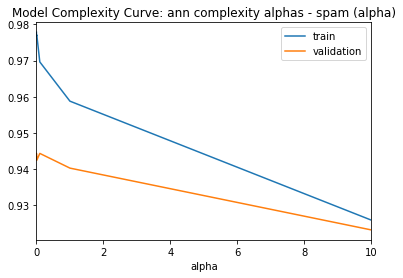

In [99]:
spam_cc_alphas.plot(title=spam_cc_alphas.name)

In [95]:
adult_cc_layers = make_complexity_curve(adult_clf, X_trans_adult_train.astype(float), y_adult_train.astype(float), "hidden_layer_sizes", adultParams['hidden_layer_sizes'],"ann complexity", "adult")

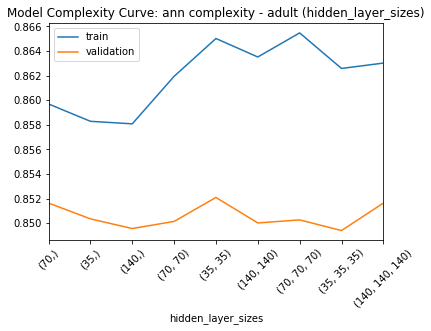

In [96]:
adult_cc_layers.plot(title=adult_cc_layers.name, rot=45)

In [97]:
spam_cc_layers = make_complexity_curve(spam_clf, X_trans_spam_train.astype(float), y_spam_train.astype(float), "hidden_layer_sizes", spamParams['hidden_layer_sizes'],"ann complexity", "spam")

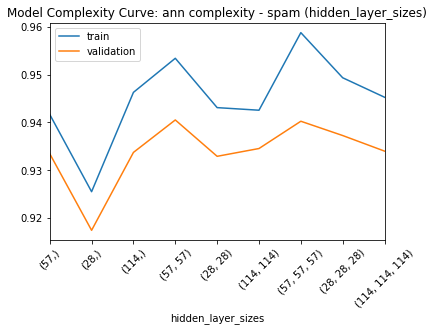

In [98]:
spam_cc_layers.plot(title=spam_cc_layers.name, rot=45)

**Timing curve**

In [17]:
adult_timing = make_timing_curve(adult_cv.best_estimator_,X_trans_adult_train.astype(float), y_adult_train.astype(float),'ann timing', 'adult')

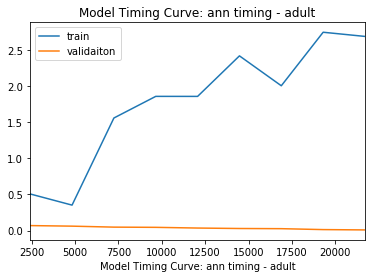

In [18]:
adult_timing.plot(title=adult_timing.name)

In [19]:
spam_timing = make_timing_curve(spam_cv.best_estimator_,X_trans_spam_train.astype(float), y_spam_train.astype(float),'ann timing', 'spam')

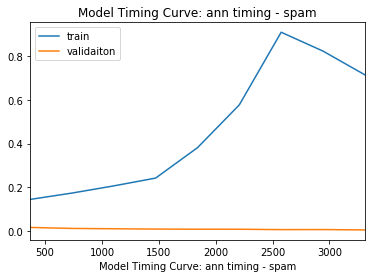

In [20]:
spam_timing.plot(title=spam_timing.name)

**Learning Curve**

In [82]:
adult_lc = make_learning_curve(adult_cv.best_estimator_,X_trans_adult_train.astype(float), y_adult_train.astype(float),np.linspace(0.1, 1.0, 10),'ann timing', 'adult')

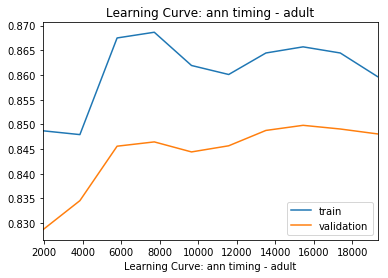

In [83]:
adult_lc.plot(title=adult_lc.name)

In [84]:
spam_lc = make_learning_curve(spam_cv.best_estimator_,X_trans_spam_train.astype(float), y_spam_train.astype(float),np.linspace(0.1, 1.0, 10),'ann timing', 'spam')

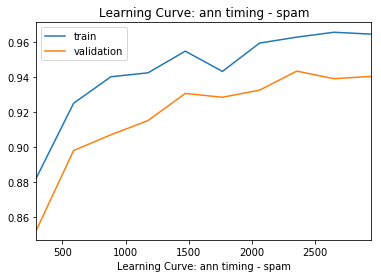

In [85]:
spam_lc.plot(title=spam_lc.name)

In [77]:
adult_clf.fit(X_trans_adult_train, y_adult_train)
spam_clf.fit(X_trans_spam_train, y_spam_train)

MLPClassifier(activation='relu', alpha=1.0, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(57, 57, 57), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=55, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

**Train accuracy**

In [78]:
print(f"Adult train score: {adult_clf.score(pipeAdult.transform(X_adult_train), y_adult_train)}")

Adult train score: 0.8587177255584566


In [79]:
print(f"Spam train score: {spam_clf.score(pipeSpam.transform(X_spam_train), y_spam_train)}")

Spam train score: 0.9630434782608696


**Test Accuracy**

In [80]:
print(f"Adult test score: {adult_clf.score(pipeAdult.transform(X_adult_test), y_adult_test)}")

Adult test score: 0.8506547323056523


In [81]:
print(f"Spam test score: {spam_clf.score(pipeSpam.transform(X_spam_test), y_spam_test)}")

Spam test score: 0.9315960912052117
